# Imports

In [1]:
from tensorflow.keras.datasets import mnist

import numpy as np
from numpy import shape

from matplotlib import pyplot as plt

import module as module
import optimizer as optimizer 
import datahandler as datahandler

import loss 


from tqdm import tqdm

2025-01-09 11:09:24.228824: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 11:09:24.233937: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 11:09:24.248670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736413764.270729    7129 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736413764.276776    7129 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 11:09:24.295675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Function for preprocessing data

In [2]:
from shuffleBatch import *

def prepocess_data(x_train, y_train, x_test, y_test, training_size, test_size):
    x_train = x_train.reshape(x_train.shape[0], 28 * 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28 * 28, 1)

    x_train = x_train.T
    x_test = x_test.T

    # filter only a specific number from train
    target_num = 7
    i = 0
    count = 0
    indeces_train = [None]*training_size
    while count < training_size:
        if y_train[i] != target_num:
            i += 1
            continue
        indeces_train[count] = i
        i += 1
        count += 1

    # filter only a specific number from test
    i = 0
    count = 0
    indeces_test = [None]*test_size
    while count < test_size:
        if y_train[i] != target_num:
            i += 1
            continue
        indeces_test[count] = i
        i += 1
        count += 1

    x_train = np.array([x_train[:, :, i] for i in indeces_train])
    x_test = np.array([x_test[:, :, i] for i in indeces_test])
    
    x_train = np.squeeze(x_train).T
    x_test = np.squeeze(x_test).T


    y_test = [y_test[i] for i in indeces_test]
    y_train = [y_train[i] for i in indeces_train]
   
    y_tr = np.zeros((10, training_size))
    y_ts = np.zeros((10, test_size))
    
    y_tr[0, :] = y_train
    y_ts[0, :] = y_test

    y_test = y_ts
    y_train = y_tr
    for i in range(training_size):
        n_tmp = int(y_train[0, i])

        
        y_train[:, i] = np.zeros(10)
        y_train[n_tmp, i] = 1
    # print(y_train)

    for i in range(test_size):
        n_tmp = int(y_test[0, i])

        y_test[:, i] = np.zeros(10)
        y_test[n_tmp, i] = 1
    # print(y_test)


    x_test, y_test = reshuffle(x_test, y_test)
    x_train, y_train = reshuffle(x_train, y_train)

    return (x_train, y_train, x_test, y_test)




# Load and preprocess data 

In [3]:
# load MNIST using Keras
training_size = 5000
test_size = 100
(x_train, y_train), (x_test, y_test) = mnist.load_data()

inDimension = 28*28

(x_train, y_train, x_test, y_test) = prepocess_data(x_train, y_train, x_test, y_test, training_size, test_size)

print(np.shape(x_test))
print(np.shape(x_train))
print(np.shape(y_test))
print(np.shape(y_train))

(784, 100)
(784, 5000)
(10, 100)
(10, 5000)


# Set a custom Loss function for the generator

In [4]:
from loss import LossFunction

class GenLoss(LossFunction):

    def __init__(self):
        self.gradOut = None
        self.valOut = None 

    def __call__(self, x, y):
        assert self.valOut is not None, 'Error: Value is not initialized'
        return self.valOut

    def gradient(self, x, y):
        assert self.gradOut is not None, 'Error: Gradient is not initialized'
        return self.gradOut
        

# Define the random merge function 
Responsible for merging a batch from the real data with the fake (generator) data.

In [5]:
import random

def randomMerge(A, B, shuffle = True):
    '''
    given two matrices A and B, merge them and shuffle the new matrix entries

    returns 
    C              :                                       merged array
    indices        :          merged indices describing the permutation
    idx_map        :  at index i contains the position that i is stored
    '''
    assert len(A) == len(B), 'A and B must be of same length at dimension 0'
    len_a = len(A[0])
    len_b = len(B[0])
    numData = len_a + len_b
    C = np.zeros((len(A), numData))
    for i in range(len(A[0])):
        C[:, i] = A[:, i]
    for i in range(len_a, numData):
        C[:, i] = B[:, i-len_a]

    indices = list(range(numData))
    if not shuffle:
        return C, indices, indices

    random.shuffle(indices)
    C = [C[:, idx] for idx in indices]
    C = np.column_stack(C)
    
    idx_map = [None]*len(indices)
    for i, idx in enumerate(indices):
        idx_map[idx] = i

    return C, indices, idx_map

A = np.ones((2, 10))
B = np.zeros((2, 11))
C, ids, idx_map = randomMerge(A, B)
print(f' A = {A}\nB={B}\nC=\n{C}\nindices={ids}\nmap = {idx_map}')

 A = [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
B=[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
C=
[[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0.]]
indices=[10, 6, 15, 14, 13, 4, 2, 18, 17, 16, 1, 5, 20, 8, 7, 11, 9, 0, 3, 12, 19]
map = [17, 10, 6, 18, 5, 11, 1, 14, 13, 16, 0, 15, 19, 4, 3, 2, 9, 8, 7, 20, 12]


# Training
## Definition of the models

In [6]:

import module as module
import optimizer as optimizer 
import loss 
import datahandler as datahandler


#
#  generator ====================================================================
generator = module.Module()
generator.appendLayer(inDimension)

for i in range(2):
    generator.appendLayer(256)

generator.appendLayer(inDimension)

generator.printShape()

# nn.setLossFunction(loss.L2Loss)
generator.setLossFunction(GenLoss)


# opt = optimizer.SGD(nn, learning_rate=0.1, dynamic_step=True)
gen_opt = optimizer.SGD(generator, dynamic_step=True, weight_normalization=True)

# dicriminator =================================================================

discriminator = module.Module()
discriminator.appendLayer(inDimension)

for i in range(2):
    discriminator.appendLayer(256)

discriminator.appendLayer(2, activation='softmax')
discriminator.printShape()
discriminator.setLossFunction(loss.CrossEntropyLoss)


dis_opt = optimizer.SGD(discriminator, dynamic_step=True, weight_normalization=True)


loss_vector_sgd_gen = []
loss_vector_sgd_dis = []

wnorm_sgd = []

# N = 100
batch_size = 100
dataHandler = datahandler.DataHandler(x_train, y_train, batch_size=batch_size)

get_noise = lambda mu, sigma, dimension, N : np.random.randn(dimension, N)*sigma + mu


Number of Layers: 4
Total Parameters: 468240 (466944 weights and 1296 biases)
Size on RAM (approximate) 3.57 Mb
(784 None) x (256 relu) x (256 relu) x (784 relu)
Weight dimensions: (256, 784), (256, 256), (784, 256)
Number of Layers: 4
Total Parameters: 267266 (266752 weights and 514 biases)
Size on RAM (approximate) 2.04 Mb
(784 None) x (256 relu) x (256 relu) x (2 softmax)
Weight dimensions: (256, 784), (256, 256), (2, 256)


## Actual training of the two models

In [7]:
no_epochs = 15
for j in tqdm(range(no_epochs), desc=f"Processing:"):
    
    dataHandler.reset()
    epoch_loss_gen = []
    epoch_loss_dis = []
    while dataHandler.hasNext():
        
        ################# take next batch from train set
        
        (batchX, batchY) = dataHandler.nextBatch()
        
        # almost always equal to the real batch_size, except for the last batch
        batchSizeTrue = len(batchX[0]) 
        batchY = np.zeros((2, batchSizeTrue))
        for i in range(batchSizeTrue):
            batchY[1,i] = 1
        # print(np.shape(batchY))

        batchY_fake = np.zeros((2, batchSizeTrue))
        for i in range(batchSizeTrue):
            batchY_fake[0, i] = 1
        
        """
        pass the batch of noise along with the label 1 into the generator
        """
        generator(get_noise(0, 1, inDimension, batchSizeTrue), batchY_fake)

        generator.forward()

        # take the generator's output and shuffle it with the actual ones
        batchX_fake = generator.output
        mixedBatchX, mixed_idcs, idx_map = randomMerge(batchX, batchX_fake, shuffle = True)
        mixedBatchX = np.array(mixedBatchX)
        

        # having kept the permutation indices, merge the labels accordingly
        mixedBatchY, _, _ = randomMerge(batchY, batchY_fake, shuffle = False)
        mixedBatchY = np.array([mixedBatchY[:, idx] for idx in mixed_idcs]).T
        

        # time to pass the augmented batch into the discriminator
        discriminator(mixedBatchX, mixedBatchY)
        discriminator.forward()

        # pray for the best
        discriminator.calc_loss()
        discriminator.backward()
        dis_opt.step()

        ########################### backpropagate generator but only wrt to their respective output
        discr_output_fake = np.array([discriminator.output[:, idx_map[ii]] for ii in range(batchSizeTrue)])
        discr_loss_fake = np.array([discriminator.loss_function(discriminator.output[:, jj], discriminator.yhat[:, jj]) for jj in range(batchSizeTrue)])
        # assuming that number of real data = number of fake data
        discr_loss_real = np.array([discriminator.loss_function(discriminator.output[:, jj], discriminator.yhat[:, jj]) for jj in range(batchSizeTrue, 2*batchSizeTrue, 1)])
        
       
        discr_grads_fake = np.array([discriminator.propagated_gradients[0][ :, idx_map[i]] for i in range(batchSizeTrue)])

        
        generator.loss_instance.valOut = -discr_loss_fake.T - discr_loss_real.T
        generator.loss_instance.gradOut = -discr_grads_fake.T
        
        
        generator.backward()
        gen_opt.step()

        epoch_loss_gen.append(np.average(generator.loss))
        epoch_loss_dis.append(np.average(discriminator.loss))
        
    
    loss_vector_sgd_gen.append(np.average(epoch_loss_gen))
    loss_vector_sgd_dis.append(np.average(epoch_loss_dis))

Processing:: 100%|██████████| 15/15 [57:52<00:00, 231.52s/it]


## print training plots

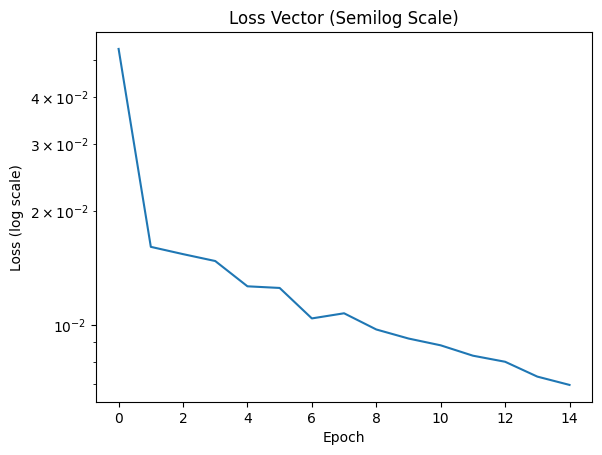

In [8]:
plt.semilogy(loss_vector_sgd_dis, '-')
plt.title('Loss Vector (Semilog Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.show()

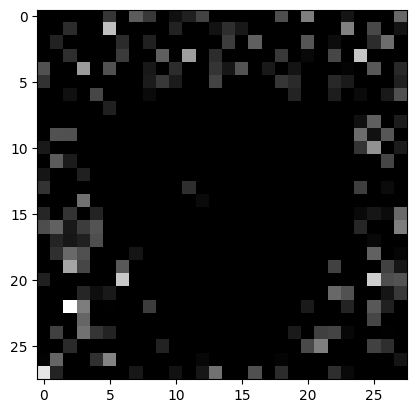

In [9]:
first_image = np.array(generator.output[:,0], dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')


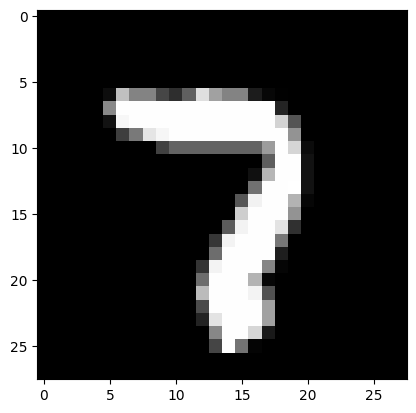

In [10]:
first_image = np.array(x_train[:, 0], dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

# Evaluate GAN
## Using True/False positives and True/False negatives

In [11]:
dataHandlerTest = datahandler.DataHandler(x_test, y_test, batch_size=1)

dataHandlerTest.reset()
k=0
false_negatives = 0
false_positives = 0
while dataHandlerTest.hasNext():
    # print(f'{k}/{test_size}')
    #####################################################33
    # Test discriminator with real data
    (batchX, batchY) = dataHandlerTest.nextBatch()
    
    # almost always equal to the real batch_size, except for the last batch
    batchSizeTrue = len(batchX[0]) 
    batchY = np.zeros((2, batchSizeTrue))
    for i in range(batchSizeTrue):
        batchY[1,i] = 1

    discriminator(batchX, batchY)
    discriminator.forward()
    k += 1
    if discriminator.output[0] > 0.5:
    
       false_negatives += 1

    #####################################################33
    # Test discriminator with fake data
    batchY_fake = np.zeros((2, batchSizeTrue))
    for i in range(batchSizeTrue):
        batchY_fake[0, i] = 1
    
    """
    pass the batch of noise along with the label 1 into the generator
    """
    generator(get_noise(0, 1, inDimension, batchSizeTrue), batchY_fake)

    generator.forward()

    # take the generator's output and shuffle it with the actual ones
    batchX_fake = generator.output

    discriminator(batchX_fake, batchY_fake)
    discriminator.forward()

    if discriminator.output[0] <= 0.5:
    
       false_positives += 1
    

false_negative_rate = false_negatives/test_size
print(f'True positive rate {1-false_negative_rate}')
print(f'False negative rate {false_negative_rate}')
    
false_positive_rate = false_positives/test_size
print(f'True negative rate {1-false_positive_rate}')
print(f'False positive rate {false_positive_rate}')


True positive rate 0.83
False negative rate 0.17
True negative rate 1.0
False positive rate 0.0


/tmp/ipykernel_7129/1387378632.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if discriminator.output[0] > 0.5:
/tmp/ipykernel_7129/1387378632.py:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if discriminator.output[0] <= 0.5:
